<a href="https://colab.research.google.com/github/chengyang122/Metter.js-and-MediaPipe-Interactive-game/blob/main/Detectron2BarcodeIdentificationPlus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install ipython-autotime
%load_ext autotime

time: 162 µs (started: 2022-04-22 05:05:27 +00:00)


In [1]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

torch:  1.10 ; cuda:  cu111
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html


In [2]:
import numpy as np
import json
import pandas as pd
import cv2
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [3]:
img_address_base = '/content/drive/MyDrive/barcode/Ananya.zip (Unzipped Files)/'
df = pd.read_excel('/content/drive/MyDrive/barcode/AnanyaAnnotation_10-09-2017.xlsx')
df['isBarcode'] = 1
img = cv2.imread(img_address_base + df.loc[1][0] + '.jpg')

In [4]:
img_address_base = '/content/drive/MyDrive/barcode/Ananya.zip (Unzipped Files)/'
img = cv2.imread(img_address_base + str(df.loc[10][0]) + '.jpg')

In [5]:
df['ymax'] = df[['Y1','Y2', 'Y3', 'Y4']].max(axis=1)
df['ymin'] = df[['Y1','Y2', 'Y3', 'Y4']].min(axis=1)
df['xmax'] = df[['X1','X2','X3','X4']].max(axis=1)
df['xmin'] = df[['X1','X2','X3','X4']].min(axis=1)
df['width'] = img.shape[1] #since all shape are the same. Can use shape of one picture 
df['height'] = img.shape[0] #since all shape are the same. Can use shape of one picture 
df['class'] = 1
df['filename'] = df['Image Filename']+ '.jpg'
df["category_id"] = 0

In [15]:
#show the shape of the output image 
def annotation(row):
    annotation = {}
    area = (row.xmax -row.xmin)*(row.ymax - row.ymin)
    annotation["bbox"] = [row.xmin, row.ymin, row.xmax -row.xmin,row.ymax-row.ymin ]
    annotation['bbox_mode'] = 1
    annotation["category_id"] = row.category_id
    annotation["segmentation"] = [[row.X1, row.Y1, row.X2, row.Y2, row.X3, row.Y3, row.X4, row.Y4]]
    return annotation

dftrain = df[:1000]
dftest = df[1000:]

annotation_column = []
for row in dftrain.itertuples():
    annotation_column.append(annotation(row))
dftrain['annotation'] = annotation_column
g = dftrain[['Image Filename', 'annotation']].groupby('Image Filename')['annotation'].apply(list).reset_index(name='annotations')
g.columns = ['file_name','annotations']
g['width'] = 2592
g['height'] = 1944
g['image_id'] = np.arange(len(g))
g.index=np.arange(len(g))
g.reset_index(inplace=True)
g.to_json("/content/drive/MyDrive/barcode/Ananya.zip (Unzipped Files)/train_dataset.json",orient="records")

annotation_column = []
for row in dftest.itertuples():
    annotation_column.append(annotation(row))
dftest['annotation'] = annotation_column
g = dftest[['Image Filename', 'annotation']].groupby('Image Filename')['annotation'].apply(list).reset_index(name='annotations')
g.columns = ['file_name','annotations']
g['width'] = 2592
g['height'] = 1944
g['image_id'] = np.arange(len(g))
g.index=np.arange(len(g))
g.reset_index(inplace=True)
g.to_json("/content/drive/MyDrive/barcode/Ananya.zip (Unzipped Files)/test_dataset.json",orient="records")



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [16]:
import json
from detectron2.structures import BoxMode
def get_board_dicts_train():#/test_dataset.json #/train_dataset.json
    json_file = "/content/drive/MyDrive/barcode/Ananya.zip (Unzipped Files)"+ '/train_dataset.json' #Fetch the json file
    with open(json_file) as f:
        dataset_dicts = json.load(f)
    for i in dataset_dicts:
        filename = i["file_name"] 
        i["file_name"] = "/content/drive/MyDrive/barcode/Ananya.zip (Unzipped Files)"+"/"+filename +'.jpg' 
        for j in i["annotations"]:
            j["bbox_mode"] = BoxMode.XYWH_ABS #Setting the required Box Mode
            j["category_id"] = int(j["category_id"])
    return dataset_dicts

def get_board_dicts_test():#/test_dataset.json #/train_dataset.json
    json_file = "/content/drive/MyDrive/barcode/Ananya.zip (Unzipped Files)"+ '/test_dataset.json' #Fetch the json file
    with open(json_file) as f:
        dataset_dicts = json.load(f)
    for i in dataset_dicts:
        filename = i["file_name"] 
        i["file_name"] = "/content/drive/MyDrive/barcode/Ananya.zip (Unzipped Files)"+"/"+filename +'.jpg' 
        for j in i["annotations"]:
            j["bbox_mode"] = BoxMode.XYWH_ABS #Setting the required Box Mode
            j["category_id"] = int(j["category_id"])
    return dataset_dicts
from detectron2.data import DatasetCatalog, MetadataCatalog

DatasetCatalog.clear()
#Registering the Dataset
DatasetCatalog.register("boardetect_train", get_board_dicts_train)
MetadataCatalog.get("boardetect_train").set(thing_classes=["Barcode"])

DatasetCatalog.register("boardetect_test", get_board_dicts_test)
MetadataCatalog.get("boardetect_test").set(thing_classes=["Barcode"])

board_metadata_train = MetadataCatalog.get("boardetect_train")
board_metadata_test = MetadataCatalog.get("boardetect_test")

In [8]:
len(get_board_dicts_train())

119

In [ ]:
dataset_dicts = get_board_dicts_train()
#Randomly choosing 3 images from the Set
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    print(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=board_metadata_train)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [18]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("boardetect_train",)
cfg.DATASETS.TEST = ("boardetect_test",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
#trainer = DefaultTrainer(cfg) 
#trainer.resume_or_load(resume=False)
#trainer.train()

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 # set the testing threshold for this model
cfg.DATASETS.TEST = ("boardetect_test", )
predictor = DefaultPredictor(cfg)

from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_board_dicts_test()
decresult = 0
for d in random.sample(dataset_dicts, 46):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=board_metadata_test, 
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels
    )
    decresult = decresult + len(outputs['instances'])

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 # set the testing threshold for this model
cfg.DATASETS.TEST = ("boardetect_test", )
predictor = DefaultPredictor(cfg)

from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_board_dicts_test()
decresult = 0
for d in random.sample(dataset_dicts, 46):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=board_metadata_test, 
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels
    )
    decresult = decresult + len(outputs['instances'])
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])
print(f'number of detected boxes is {decresult}')


In [ ]:
len(outputs['instances'])

6

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


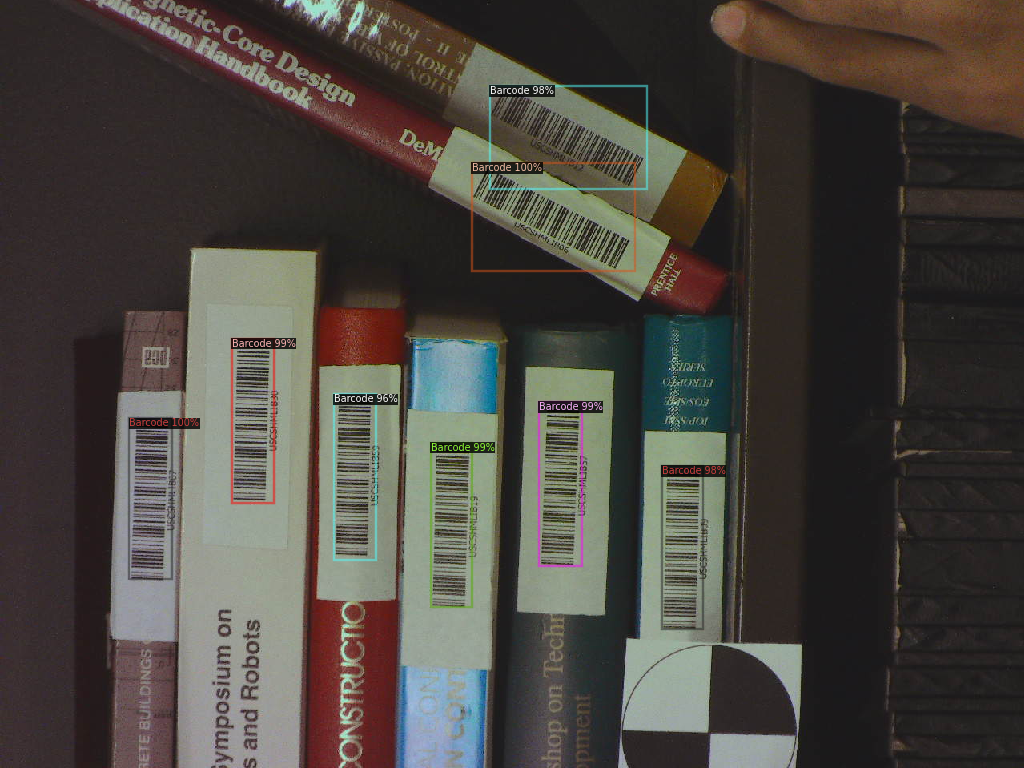

In [ ]:
im = cv2.imread('/content/drive/MyDrive/barcode/capture_2018_08_08_05_30_52.png')
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
                metadata=board_metadata_test, 
                scale=0.8,
                instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
outputs["instances"].to("cpu").pred_boxes.tensor.detach().numpy() 

In [ ]:
dataset_dicts[0]['file_name']

'/content/drive/MyDrive/barcode/Ananya.zip (Unzipped Files)/20170713-16_16_19-RPI1-camC_undistored.jpg'

In [ ]:
import cv2
import cv2 as cv
import numpy as np
from skimage.morphology import octagon
from scipy.signal import medfilt2d
from skimage.filters.rank import tophat, bottomhat
from tensorflow.keras.preprocessing import image
from skimage import measure
from skimage.measure import regionprops
from skimage.measure import regionprops_table
from scipy.stats import norm
import warnings
import matplotlib.pyplot as plt
from scipy.ndimage import binary_opening
warnings.filterwarnings('ignore')
import os
from google.colab.patches import cv2_imshow
from skimage import morphology
import pandas as pd
from skimage import io, morphology
import matplotlib.pyplot as plt
from PIL import Image as im
import matplotlib.pyplot as plt
import skimage
from skimage.io import imread, imshow
from skimage.color import rgb2gray, rgb2hsv
from skimage.measure import label, regionprops, regionprops_table
from skimage.filters import threshold_otsu
from scipy.ndimage import median_filter
from matplotlib.patches import Rectangle
from tqdm import tqdm
from PIL import Image as im
%matplotlib inline

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2990 * b + 0.5870 * g + 0.1140 * r
    return gray
def matlab_disk(radius):
  new_radius = radius - 1
  y,x = np.ogrid[-new_radius: new_radius+1, -new_radius: new_radius+1]
  mask = x**2+y**2<radius**2
  return mask.astype(int)
def show_area(regCo, theimage, rotation):
  fig, ax = plt.subplots(1,1)
  img = theimage[int(regCo[0]):int(regCo[2]), int(regCo[1]):int(regCo[3])]
  rotated_img = ndimage.rotate(img, rotation)
  ax.imshow(rotated_img)
def imoverlay(newImage, mask):
  newImage[:,:,0][mask>0]=255
  newImage[:,:,1][mask>0]=0
  newImage[:,:,2][mask>0]=0
  return newImage



def OrignialDetection(imfilname1):
  imCamA  = cv2.imread(imfilname1)
  SE_Radius = [(3, 2), (5, 4), (7, 6), (9, 8), (11, 10)]
  delsig = 0.0
  seTopBotHat = octagon(7, 6)
  seDilate = np.array(matlab_disk(5), dtype = np.uint8)#are different
  seClose  = np.array(matlab_disk(5), dtype = np.uint8)#are different
  seOpenLast = np.array(matlab_disk(5), dtype = np.uint8)#are different
  IgrayArray  = np.zeros((3,1))
  rgbArray    = np.zeros((3,1))
  fileNames = [imCamA, imCamA, imCamA]
  [rows, cols, colordepth] = fileNames[0].shape
  multiscaleResponseimgold = np.zeros((rows,cols))
  IgrayArray = []
  imgCnt = 1
  imUndistored = fileNames[0]
  gray = rgb2gray(imUndistored)
  Igray  = medfilt2d(gray,[5,5])
  Igray = np.rint(Igray)
  #Igray_norm = cv2.normalize(Igray, None, alpha=0, beta=1,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
  #tophatimg = tophat(Igray_norm, seTopBotHat)
  tophatimg = cv2.morphologyEx(Igray, cv2.MORPH_TOPHAT,seTopBotHat)
  #bothatimg = bottomhat(Igray_norm, seTopBotHat)
  bothatimg = cv2.morphologyEx(Igray, cv2.MORPH_BLACKHAT,seTopBotHat)
  enhanceimg = tophatimg+bothatimg
  dilateimg = cv2.dilate(enhanceimg,seDilate)
  closeimg  = cv2.morphologyEx(dilateimg,cv2.MORPH_CLOSE,seClose)
  for i in range(len(SE_Radius)-1):
    seOpen1   = octagon(*SE_Radius[i])
    seOpen2   = octagon(*SE_Radius[i+1])
    IMopen_new1 = cv2.morphologyEx(closeimg, cv2.MORPH_OPEN, seOpen1)
    IMopen_new2 = cv2.morphologyEx(closeimg, cv2.MORPH_OPEN, seOpen2)
    multiscaleResponseimgnew = np.maximum(IMopen_new1, IMopen_new2)
    multiscaleResponseimgold = np.maximum(multiscaleResponseimgold,multiscaleResponseimgnew)
  openCloseimg   = cv2.morphologyEx(cv2.morphologyEx(multiscaleResponseimgnew,cv2.MORPH_OPEN,seOpenLast),cv2.MORPH_CLOSE,seOpenLast)
  #openCloseimg = openclose_matlab
  #level, _ = cv2.threshold(openCloseimg,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  #_, BW = cv2.threshold(openCloseimg, 128, 255, cv2.THRESH_BINARY)
  openCloseimg = image.img_to_array(openCloseimg, dtype='uint8')
  level, BW = cv2.threshold(openCloseimg,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  CC2 = measure.label(BW)
  #CC2 = openCloseimg
  S2 = regionprops(CC2)
  area = [prop.area for prop in S2]
  mu_morph = np.mean(area)
  sigma_morph = np.std(area)**2
  cleaned = morphology.remove_small_objects(CC2, min_size=0, connectivity= 8)# weird preformance 


  testimg = np.float32(cleaned)
  ret, thresh = cv.threshold(testimg*255, 127, 255, 0)
  mg = thresh.astype(np.uint8)
  contours, hierarchy = cv.findContours(mg, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  #cv.drawContours(imCamA, contours, -1, (0,255,0), 3)
  rects = []
  for cnt in contours:
    rect = cv.minAreaRect(cnt)
    rects.append(rect)
    box = cv.boxPoints(rect)
    box = np.int0(box)
    cv.drawContours(imCamA,[box],0,(0,0,255),2)
  cv2_imshow(imCamA)

time: 171 ms (started: 2022-04-15 20:26:41 +00:00)


In [ ]:
for i in range(len(dataset_dicts)):
  imfilname1 = dataset_dicts[i]['file_name']
  OrignialDetection(imfilname1)

time: 10min 42s (started: 2022-04-15 20:08:42 +00:00)


In [ ]:
for i in range(len(dataset_dicts)):
  imfilname1 = dataset_dicts[i]['file_name']
  OrignialDetection(imfilname1)